In [1]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn import svm
from string import ascii_letters
import time

In [2]:
posts = pd.read_csv('posts_cleaned.csv')
posts.head()

,Unnamed: 0,featured,weekday,len_name,len_description,post_id,post_name,post_description,reviews_rating,topics_count
0,0,0,4,28,159,285247,SMART Operational Management,If remote teams and outsourcing were already o...,0.0,1
1,1,0,4,17,261,285246,siscertifications,ISO 14001 certification has become the interna...,0.0,1
2,2,0,4,28,256,285245,KSemantics for Google Sheets,KSemantics is an AI-powered Google Sheets add-...,0.0,4
3,3,0,4,37,180,285244,Best Mental Health Services in Lahore,Psychconsultants provides best mental health s...,0.0,2
4,4,0,4,9,122,285243,Whitebird,"Whitebird is an open-source, web-based, collab...",0.0,2


In [3]:
mappings = pd.read_csv('mapping_cleaned.csv')
mappings.head()

,Unnamed: 0,post_id,topic_id
0,0,285247,46
1,1,285246,46
2,2,285245,46
3,3,285245,108
4,4,285245,268


In [4]:
topics = pd.read_csv('topics_cleaned.csv')
topics.head()

,Unnamed: 0,year,followers_count,posts_count,topic_id
0,0,2020,69,20,472
1,1,2020,107,76,471
2,2,2020,174,77,470
3,3,2020,190,92,469
4,4,2020,157,86,468


## Data Preperation for Machine Learning

In [5]:
# drop unneeded columns
topics = topics.drop(columns=['Unnamed: 0'])
posts = posts.drop(columns=['Unnamed: 0', 'post_name', 'post_description'])
mappings = mappings.drop(columns=['Unnamed: 0'])

In [6]:
# merge topics with mapping
topics_enhanced = pd.merge(mappings, topics, on='topic_id', how='left')

In [8]:
topics_enhanced.isna().sum()

post_id            0
topic_id           0
year               0
followers_count    0
posts_count        0
dtype: int64

In [9]:
# create a list of unique posts
unique_post_ids = mappings.post_id.unique().tolist()

# create an empty dataframe
interims_df = pd.DataFrame(columns=['post_id',
                                    'topic_list',
                                    'newest_topic_year',
                                    'total_topics_posts',
                                    'total_topics_followers'])

for post_id in (unique_post_ids):
    #print(post_id)
    topics = []
    oldest_topic_year = 0
    total_topics_posts = 0
    total_topics_followers = 0
    newest_topic_year = 0
    mini_post_df = topics_enhanced.loc[topics_enhanced['post_id'] == post_id].reset_index()
    for i in range(len(mini_post_df)):
        #print(i)
        #print(mini_post_df.loc[[i]])
        row = mini_post_df.loc[[i]]
        #print(row.topic_id)
        topics.append(int(row.topic_id))
        #print("Total " + str(type(total_topics_posts)))
        #print("Added " + str(row.posts_count))
        total_topics_posts += int(row.posts_count)
        #print("Total " + str(total_topics_posts))
        total_topics_followers += int(row.followers_count)
        #print("Total_f " + str(total_topics_followers))
        if (mini_post_df.loc[i,'year']) > newest_topic_year:
            newest_topic_year = (mini_post_df.loc[i,'year'])
    new_row = pd.Series(data={'post_id': post_id ,
               'topic_list' : topics,
               'newest_topic_year': newest_topic_year,
               'total_topics_posts': total_topics_posts,
               'total_topics_followers': total_topics_followers})
    
    interims_df = interims_df.append(new_row, ignore_index=True)
    #print(post_topics_df.head())
interims_df.head()

,post_id,topic_list,newest_topic_year,total_topics_posts,total_topics_followers
0,285247,[46],2016,42928,415416
1,285246,[46],2016,42928,415416
2,285245,"[46, 108, 268, 352]",2016,174059,1136469
3,285244,"[164, 352]",2016,140349,554742
4,285243,"[46, 272]",2016,45451,449662


In [10]:
# Convert columns to int
c_to_numeric = ['post_id',
                'newest_topic_year',
                'total_topics_posts',
                'total_topics_followers']
interims_df[c_to_numeric] =  interims_df[c_to_numeric].apply(pd.to_numeric)

In [11]:
print(len(interims_df))
print(len(posts))

26421
28000


In [12]:
merged_df = pd.merge(posts, interims_df, on='post_id', how='left')
merged_df.head()


#interims_df['post_id'] = posts.loc[:5344,'post_id']
#merged_df = pd.merge(posts, interims_df, on='post_id', how='left')
#merged_df.head()

,featured,weekday,len_name,len_description,post_id,reviews_rating,topics_count,topic_list,newest_topic_year,total_topics_posts,total_topics_followers
0,0,4,28,159,285247,0.0,1,[46],2016.0,42928.0,415416.0
1,0,4,17,261,285246,0.0,1,[46],2016.0,42928.0,415416.0
2,0,4,28,256,285245,0.0,4,"[46, 108, 268, 352]",2016.0,174059.0,1136469.0
3,0,4,37,180,285244,0.0,2,"[164, 352]",2016.0,140349.0,554742.0
4,0,4,9,122,285243,0.0,2,"[46, 272]",2016.0,45451.0,449662.0


In [13]:
# fill columns with 0 with not topic
merged_df['topic_list'] = merged_df['topic_list'].fillna('')
merged_df['newest_topic_year'] = merged_df['newest_topic_year'].fillna(0)
merged_df['total_topics_posts'] = merged_df['total_topics_posts'].fillna(0)
merged_df['total_topics_followers'] = merged_df['total_topics_followers'].fillna(0)

In [14]:
# Convert float to Int
merged_df['newest_topic_year'] = merged_df['newest_topic_year'].astype(int) 
merged_df['total_topics_posts'] = merged_df['total_topics_posts'].astype(int) 
merged_df['total_topics_followers'] = merged_df['total_topics_followers'].astype(int) 

In [15]:
merged_df.columns

Index(['featured', 'weekday', 'len_name', 'len_description', 'post_id',
       'reviews_rating', 'topics_count', 'topic_list', 'newest_topic_year',
       'total_topics_posts', 'total_topics_followers'],
      dtype='object')

In [16]:
#merged_df = merged_df.drop(columns=['post_name', 'post_description'])

In [17]:
# create df with dummies
dummy_df = pd.get_dummies(merged_df['topic_list'].apply(pd.Series).stack()).sum(level=0)
dummy_df.head()

,1.0,2.0,3.0,4.0,6.0,8.0,9.0,11.0,12.0,13.0,...,374.0,375.0,402.0,435.0,468.0,469.0,470.0,471.0,472.0,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Add dummies
merged_df_with_dummies = pd.merge(merged_df, dummy_df, left_index=True, right_index=True, how='left')
merged_df_with_dummies.head()

,featured,weekday,len_name,len_description,post_id,reviews_rating,topics_count,topic_list,newest_topic_year,total_topics_posts,...,374.0,375.0,402.0,435.0,468.0,469.0,470.0,471.0,472.0,
0,0,4,28,159,285247,0.0,1,[46],2016,42928,...,0,0,0,0,0,0,0,0,0,0
1,0,4,17,261,285246,0.0,1,[46],2016,42928,...,0,0,0,0,0,0,0,0,0,0
2,0,4,28,256,285245,0.0,4,"[46, 108, 268, 352]",2016,174059,...,0,0,0,0,0,0,0,0,0,0
3,0,4,37,180,285244,0.0,2,"[164, 352]",2016,140349,...,0,0,0,0,0,0,0,0,0,0
4,0,4,9,122,285243,0.0,2,"[46, 272]",2016,45451,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Create bins for Likelihood chart

In [20]:
# creating bins
bins = [0, 0.00000000001, 5, 10, 20]
labels = ['0', '1-5', '6-10', '11-20']
merged_df['binned_topics_count'] = pd.cut(merged_df['topics_count'], bins=bins, labels=labels)

In [21]:
# creating bins
bins = [0, 0.00000000001, 5, 10, 50]
labels = ['0', '1-5', '6-10', '11-50']
merged_df['binned_len_name'] = pd.cut(merged_df['len_name'], bins=bins, labels=labels)

In [22]:
# creating bins
bins = [0, 0.00000000001, 100, 200, 300, 400, 500]
labels = ['0', '1-100', '101-200', '201-300', '301-400', '401-500']
merged_df['binned_len_description'] = pd.cut(merged_df['len_description'], bins=bins, labels=labels)

In [23]:
# creating bins
bins = [-1, 0,  1, 2, 3, 4, 5]
labels = ['0', '0-1', '1-2', '2-3', '3-4', '4-5']
merged_df['binned_reviews_rating'] = pd.cut(merged_df['reviews_rating'], bins=bins, labels=labels)

In [24]:
# creating bins
bins = [-1, 0, 100000, 200000, 300000, 400000]
labels = ['0', '0-100k', '100-200k', '200-300k', '300-400k']
merged_df['binned_total_topics_posts'] = pd.cut(merged_df['total_topics_posts'], bins=bins, labels=labels)

In [25]:
# creating bins
bins = [-1, 0, 0.5*1000000, 1*1000000, 1.5*1000000, 2*1000000, 2.5*1000000]
labels = ['0', '0-500k', '0.5-1 Mio.', '1-1.5 Mio', '1.5-2 Mio', '2-2.5 Mio']
merged_df['binned_total_total_topics_followers'] = pd.cut(merged_df['total_topics_followers'], bins=bins, labels=labels)

In [26]:
merged_df = merged_df.fillna('0')

In [27]:
# Create bins for Likelihood Numbers

In [28]:
# creating bins
bins = [0, 0.00000000001, 5, 10, 20]
labels = [0, 5, 10, 20]
merged_df['binned_topics_count_numeric'] = pd.cut(merged_df['topics_count'], bins=bins, labels=labels)

In [29]:
# creating bins
bins = [0, 0.00000000001, 5, 10, 50]
labels = [0, 5, 10, 50]
merged_df['binned_len_name_numeric'] = pd.cut(merged_df['len_name'], bins=bins, labels=labels)

In [30]:
# creating bins
bins = [0, 0.00000000001, 100, 200, 300, 400, 500]
labels = [0, 100, 200, 300, 400, 500]
merged_df['binned_len_description_numeric'] = pd.cut(merged_df['len_description'], bins=bins, labels=labels)

In [31]:
# creating bins
bins = [-1, 0,  1, 2, 3, 4, 5]
labels = [0,  1, 2, 3, 4, 5]
merged_df['binned_reviews_rating_numeric'] = pd.cut(merged_df['reviews_rating'], bins=bins, labels=labels)

In [32]:
# creating bins
bins = [-1, 0, 100000, 200000, 300000, 400000]
labels = [0, 100000, 200000, 300000, 400000]
merged_df['binned_total_topics_posts_numeric'] = pd.cut(merged_df['total_topics_posts'], bins=bins, labels=labels)

In [33]:
# creating bins
bins = [-1, 0, 0.5*1000000, 1*1000000, 1.5*1000000, 2*1000000, 2.5*1000000]
labels = [0, 0.5*1000000, 1*1000000, 1.5*1000000, 2*1000000, 2.5*1000000]
merged_df['binned_total_total_topics_followers_numeric'] = pd.cut(merged_df['total_topics_followers'], bins=bins, labels=labels)

In [34]:
merged_df = merged_df.fillna({'binned_topics_count_numeric':0,
                              'binned_len_name_numeric':0,
                              'binned_len_description_numeric':0,
                              'binned_reviews_rating_numeric':0,
                              'binned_total_topics_posts_numeric':0, 
                              'binned_total_total_topics_followers_numeric':0
                             })

In [35]:
merged_df.to_csv('/Users/theresawohlsen/code/bi/merged_df.csv')

In [36]:
merged_df.columns

Index(['featured', 'weekday', 'len_name', 'len_description', 'post_id',
       'reviews_rating', 'topics_count', 'topic_list', 'newest_topic_year',
       'total_topics_posts', 'total_topics_followers', 'binned_topics_count',
       'binned_len_name', 'binned_len_description', 'binned_reviews_rating',
       'binned_total_topics_posts', 'binned_total_total_topics_followers',
       'binned_topics_count_numeric', 'binned_len_name_numeric',
       'binned_len_description_numeric', 'binned_reviews_rating_numeric',
       'binned_total_topics_posts_numeric',
       'binned_total_total_topics_followers_numeric'],
      dtype='object')

## Data Exploration

### Functions to explore dfs

In [37]:
def explore_df(df):
    print("Shape: ")
    print(df.shape)
    print("------------------------------------------")
    
    print("Head: ")
    print(df.head())
    print("------------------------------------------")
    
    print("Tail: ")
    print(df.tail() )     
    print("------------------------------------------")
    
    print("Describe: ")
    print(df.describe())
    print("------------------------------------------")
    
    print("Info: ")   
    print(df.info())
    print("------------------------------------------")
    
    print("Missing Values: ")   
    print(df.isna().sum())
    print("------------------------------------------")
    
    print("Info: ")   
    print(df.info())
    print("------------------------------------------")
    

In [79]:
def create_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap  correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
def create_count_plots(df,columns):
    for feature in columns:
        sns.countplot(x=feature, data=df, color="orangered")
        plt.show()

In [40]:
def create_histogram(df, columns):
    for feature in columns:
        print(feature)
        df[feature].hist(color="orangered")
        plt.show()

###  Data Exploration

In [41]:
explore_df(merged_df)

Shape: 
(28000, 23)
------------------------------------------
Head: 
   featured  weekday  len_name  len_description  post_id  reviews_rating  \
0         0        4        28              159   285247             0.0   
1         0        4        17              261   285246             0.0   
2         0        4        28              256   285245             0.0   
3         0        4        37              180   285244             0.0   
4         0        4         9              122   285243             0.0   

   topics_count           topic_list  newest_topic_year  total_topics_posts  \
0             1                 [46]               2016               42928   
1             1                 [46]               2016               42928   
2             4  [46, 108, 268, 352]               2016              174059   
3             2           [164, 352]               2016              140349   
4             2            [46, 272]               2016               45451   

In [42]:
merged_df.columns

Index(['featured', 'weekday', 'len_name', 'len_description', 'post_id',
       'reviews_rating', 'topics_count', 'topic_list', 'newest_topic_year',
       'total_topics_posts', 'total_topics_followers', 'binned_topics_count',
       'binned_len_name', 'binned_len_description', 'binned_reviews_rating',
       'binned_total_topics_posts', 'binned_total_total_topics_followers',
       'binned_topics_count_numeric', 'binned_len_name_numeric',
       'binned_len_description_numeric', 'binned_reviews_rating_numeric',
       'binned_total_topics_posts_numeric',
       'binned_total_total_topics_followers_numeric'],
      dtype='object')

In [43]:
merged_df.dtypes

featured                                          int64
weekday                                           int64
len_name                                          int64
len_description                                   int64
post_id                                           int64
reviews_rating                                  float64
topics_count                                      int64
topic_list                                       object
newest_topic_year                                 int64
total_topics_posts                                int64
total_topics_followers                            int64
binned_topics_count                            category
binned_len_name                                category
binned_len_description                         category
binned_reviews_rating                          category
binned_total_topics_posts                      category
binned_total_total_topics_followers            category
binned_topics_count_numeric                    c

<font color=orangered>**Finding:** <br>
Some posts have no description. There are no NaNs.</font>

In [44]:
merged_df['featured'].value_counts()

0    20322
1     7678
Name: featured, dtype: int64

In [45]:
print("Percentage of not featured posts: ",
      str(round(len(merged_df[merged_df['featured']==0])/(len(merged_df))*100,2)),
      "%")
print("Percentage of not featured posts: ",
      str(round(len(merged_df[merged_df['featured']==1])/(len(merged_df))*100,2)),
      "%")

Percentage of not featured posts:  72.58 %
Percentage of not featured posts:  27.42 %


<font color=blue>**Finding:** <br>
The classes are inbalanced. With 1981 out of 5580 posts are featured, the dataset is a quite balanced dataset.</font>

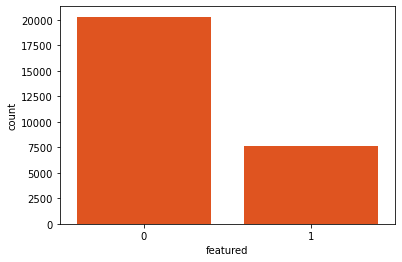

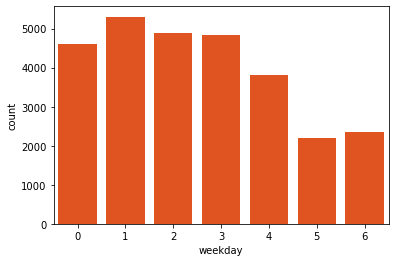

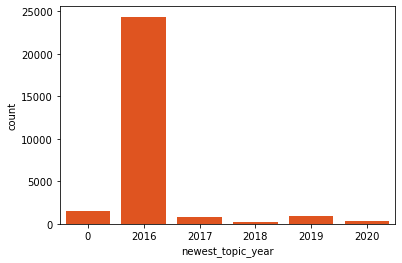

In [46]:
# Create plots
columns = ['featured',  'weekday', 'newest_topic_year']
create_count_plots(merged_df, columns)

topics_count


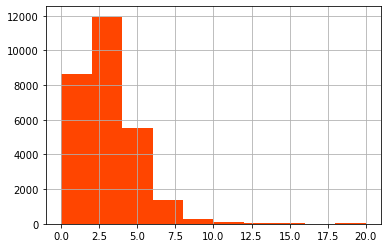

len_name


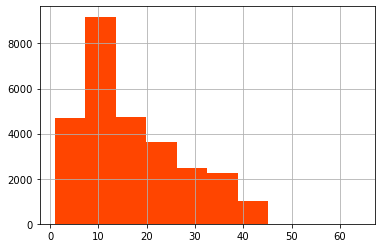

len_description


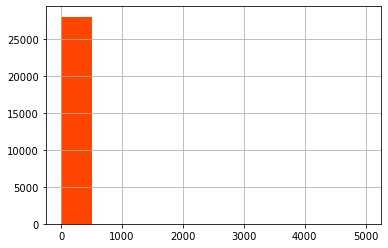

total_topics_posts


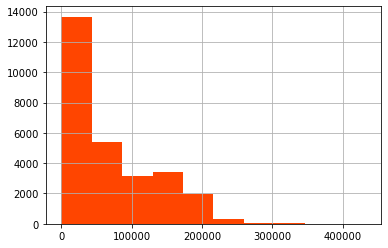

total_topics_followers


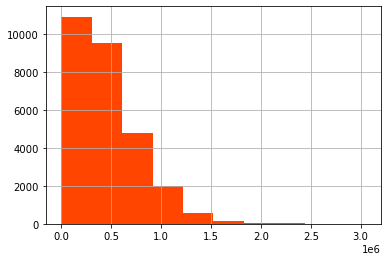

In [47]:
# Create histograms

columns = ['topics_count', 'len_name', 'len_description',
           'total_topics_posts', 'total_topics_followers']
create_histogram(merged_df, columns)

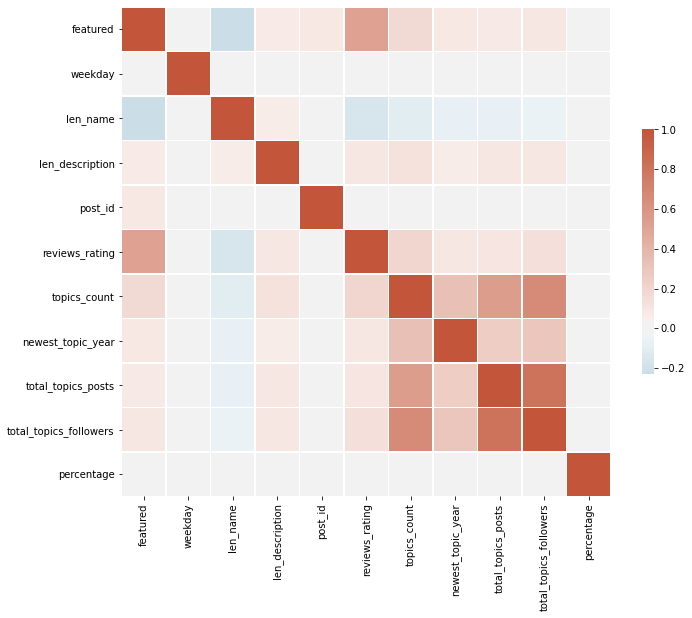

In [80]:
create_correlation_matrix(merged_df)

<font color=blue>**Finding:** <br>
It is a balanced dataset.</font>

## Machine Learning

In [49]:
merged_df.columns

Index(['featured', 'weekday', 'len_name', 'len_description', 'post_id',
       'reviews_rating', 'topics_count', 'topic_list', 'newest_topic_year',
       'total_topics_posts', 'total_topics_followers', 'binned_topics_count',
       'binned_len_name', 'binned_len_description', 'binned_reviews_rating',
       'binned_total_topics_posts', 'binned_total_total_topics_followers',
       'binned_topics_count_numeric', 'binned_len_name_numeric',
       'binned_len_description_numeric', 'binned_reviews_rating_numeric',
       'binned_total_topics_posts_numeric',
       'binned_total_total_topics_followers_numeric'],
      dtype='object')

### Prepare Train / Test Data without dummies

In [50]:
features_without_dummies = ['weekday', 'len_name', 'len_description',
                            'topics_count', 'reviews_rating',
                            'newest_topic_year', 'total_topics_posts', 'total_topics_followers']

In [51]:
features = features_without_dummies
df = merged_df  
    
X = df[features].to_numpy()
y = df.featured.to_numpy()

In [52]:
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 20322, 1: 7678})
Counter({0: 20322, 1: 20322})


In [53]:
train_x , test_x, train_y, test_y = train_test_split(X,y, test_size=0.3,random_state=0)

## Train and Test Model

In [54]:
def train_test_model(model,
                     train_x=train_x,
                     train_y=train_y,
                     test_y=test_y,
                     test_x=test_x):
    start_time = time.time()
    model.fit(train_x, train_y)
    training_time = time.time()
    print('training took %fs!' % (training_time - start_time))

    predict = model.predict(test_x)
    predict_time = time.time()
    print('predicting took %fs!' % (predict_time - training_time))

    print(classification_report(test_y, predict))

In [55]:
train_test_model(KNeighborsClassifier())

training took 0.098250s!
predicting took 0.698231s!
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      6102
           1       0.69      0.78      0.74      6092

    accuracy                           0.72     12194
   macro avg       0.72      0.72      0.72     12194
weighted avg       0.72      0.72      0.72     12194



In [56]:
train_test_model(svm.SVC())

training took 111.460616s!
predicting took 42.816928s!
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      6102
           1       0.57      0.55      0.56      6092

    accuracy                           0.57     12194
   macro avg       0.57      0.57      0.57     12194
weighted avg       0.57      0.57      0.57     12194



In [57]:
train_test_model(svm.LinearSVC())

training took 4.790188s!
predicting took 0.004888s!
              precision    recall  f1-score   support

           0       0.57      0.40      0.47      6102
           1       0.54      0.70      0.61      6092

    accuracy                           0.55     12194
   macro avg       0.55      0.55      0.54     12194
weighted avg       0.55      0.55      0.54     12194



/Users/theresawohlsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [58]:
train_test_model(DecisionTreeClassifier())

training took 0.245001s!
predicting took 0.002863s!
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      6102
           1       0.82      0.82      0.82      6092

    accuracy                           0.82     12194
   macro avg       0.82      0.82      0.82     12194
weighted avg       0.82      0.82      0.82     12194



In [59]:
train_test_model(RandomForestClassifier())

training took 4.129708s!
predicting took 0.261826s!
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6102
           1       0.88      0.85      0.87      6092

    accuracy                           0.87     12194
   macro avg       0.87      0.87      0.87     12194
weighted avg       0.87      0.87      0.87     12194



In [60]:
train_test_model(ExtraTreesClassifier())

training took 2.637697s!
predicting took 0.385635s!
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6102
           1       0.87      0.86      0.87      6092

    accuracy                           0.87     12194
   macro avg       0.87      0.87      0.87     12194
weighted avg       0.87      0.87      0.87     12194



### Best performing ML

In [61]:
model = RandomForestClassifier()
start_time = time.time()
model.fit(train_x, train_y)
training_time = time.time()
print('training took %fs!' % (training_time - start_time))

predict = model.predict(test_x)
predict_time = time.time()
print('predicting took %fs!' % (predict_time - training_time))


training took 3.840646s!
predicting took 0.243177s!


In [62]:
model.feature_importances_


array([0.06775823, 0.12998756, 0.10972953, 0.05497206, 0.43833103,
       0.01965093, 0.08819446, 0.09137619])

<BarContainer object of 8 artists>

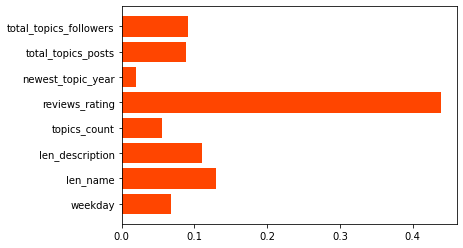

In [63]:
plt.barh(features, model.feature_importances_, color="orangered")

### Train and Test with Dummies

In [65]:
dummy_features = dummy_df.columns.to_list()
features_with_dummies = dummy_features + features_without_dummies

features = features_with_dummies
df = merged_df_with_dummies
       
X = df[features].to_numpy()
y = df.featured.to_numpy()


# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

train_x , test_x, train_y, test_y = train_test_split(X,y, test_size=0.3,random_state=0)

Counter({0: 20322, 1: 7678})
Counter({0: 20322, 1: 20322})


In [66]:
train_test_model(KNeighborsClassifier())

training took 0.076631s!
predicting took 0.860834s!
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      6102
           1       0.69      0.78      0.74      6092

    accuracy                           0.72     12194
   macro avg       0.72      0.72      0.72     12194
weighted avg       0.72      0.72      0.72     12194



In [67]:
train_test_model(svm.SVC())

training took 70.793923s!
predicting took 41.032881s!
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      6102
           1       0.57      0.55      0.56      6092

    accuracy                           0.57     12194
   macro avg       0.57      0.57      0.57     12194
weighted avg       0.57      0.57      0.57     12194



In [68]:
train_test_model(svm.LinearSVC())

training took 4.563649s!
predicting took 0.002798s!
              precision    recall  f1-score   support

           0       0.84      0.27      0.41      6102
           1       0.57      0.95      0.71      6092

    accuracy                           0.61     12194
   macro avg       0.70      0.61      0.56     12194
weighted avg       0.70      0.61      0.56     12194



/Users/theresawohlsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [69]:
train_test_model(DecisionTreeClassifier())

training took 0.237297s!
predicting took 0.004451s!
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      6102
           1       0.82      0.81      0.82      6092

    accuracy                           0.82     12194
   macro avg       0.82      0.82      0.82     12194
weighted avg       0.82      0.82      0.82     12194



In [70]:
train_test_model(RandomForestClassifier())

training took 3.656161s!
predicting took 0.231012s!
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6102
           1       0.88      0.85      0.87      6092

    accuracy                           0.87     12194
   macro avg       0.87      0.87      0.87     12194
weighted avg       0.87      0.87      0.87     12194



In [71]:
train_test_model(ExtraTreesClassifier())

training took 2.258970s!
predicting took 0.508276s!
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6102
           1       0.88      0.86      0.87      6092

    accuracy                           0.87     12194
   macro avg       0.87      0.87      0.87     12194
weighted avg       0.87      0.87      0.87     12194



### Likelihood

In [72]:
# Liklihood
def get_lilklihood(df, feature):
    distribution_of_feature = df.groupby([feature,'featured'])['percentage'].sum()
    highest_chance = ""
    chance = 0
    for i in range(round(len(distribution_of_feature)/2)):
        try:
            a = distribution_of_feature[i][0]
            b = distribution_of_feature[i][1]
            c = round(b / (a+b) *100)
            #x = distribution_of_feature[i][1]/likelihood_to_be_featured[1]*100
            distribution_of_feature.reset_index
            j = i*2
            name = distribution_of_feature.index[j][0]
            print("Liklihood of being featured, when " + str(name)+ " is the "  + feature + " is: " + str(c) + "%") 
            if c > chance:
                highest_chance =  name
                chance = c
        except:
            pass

    print("Highest Liklihood of being featured is with " +
          str(highest_chance)+ " as "  + feature +
          ". Your Chance is: " + str(chance) + "%")   

In [73]:
def get_liklihood_charts(df, feature):
    plotPercentage = sns.barplot(x=feature, y='featured', hue='featured', color="orangered",
                             data=df, estimator=lambda x: len(x) / len(merged_df)*100)
    plotPercentage.set(ylabel="Post being featured")
    total = float(len(['featured']))
    for p in plotPercentage.patches:
        height = p.get_height()
        plotPercentage.text(p.get_x()+p.get_width()/2.,
                            height + 3,
                            '{:1.2f}'.format(height/total),
                            ha="center") 
    plt.show()
    

In [74]:
liklihood_df = merged_df
liklihood_df['percentage']= 1/len(liklihood_df)
likelihood_to_be_featured = liklihood_df.groupby(['featured'])['percentage'].sum()

In [75]:
features_likelihood= ['weekday',
                      'binned_topics_count_numeric', 
                      'binned_len_name_numeric',
                      'binned_len_description_numeric', 
                      'binned_reviews_rating_numeric',
                      'binned_total_topics_posts_numeric', 
                      'binned_total_total_topics_followers_numeric']

In [76]:
for feature in features_likelihood:
    get_lilklihood(liklihood_df, feature)

Liklihood of being featured, when 0 is the weekday is: 26.0%
Liklihood of being featured, when 1 is the weekday is: 28.0%
Liklihood of being featured, when 2 is the weekday is: 28.0%
Liklihood of being featured, when 3 is the weekday is: 29.0%
Liklihood of being featured, when 4 is the weekday is: 27.0%
Liklihood of being featured, when 5 is the weekday is: 22.0%
Liklihood of being featured, when 6 is the weekday is: 30.0%
Highest Liklihood of being featured is with 6 as weekday. Your Chance is: 30.0%
Liklihood of being featured, when 0 is the binned_topics_count_numeric is: 12.0%
Highest Liklihood of being featured is with 0 as binned_topics_count_numeric. Your Chance is: 12.0%
Liklihood of being featured, when 0 is the binned_len_name_numeric is: nan%
Highest Liklihood of being featured is with  as binned_len_name_numeric. Your Chance is: 0%
Liklihood of being featured, when 0 is the binned_len_description_numeric is: 8.0%
Highest Liklihood of being featured is with 0 as binned_len_d

In [77]:
features_chart = ['weekday',
                  'binned_topics_count',
                  'binned_len_name',
                  'binned_len_description',
                  'binned_reviews_rating',
                  'binned_total_topics_posts',
                  'binned_total_total_topics_followers']

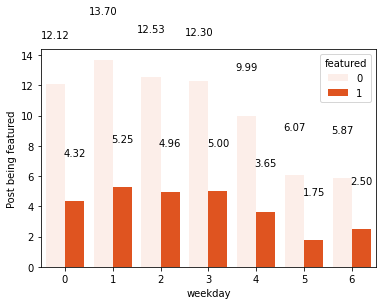

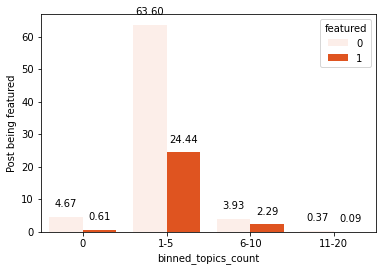

posx and posy should be finite values
posx and posy should be finite values


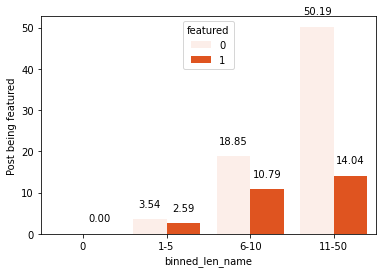

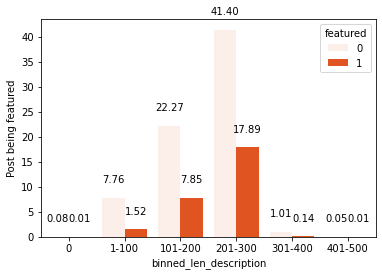

posx and posy should be finite values
posx and posy should be finite values


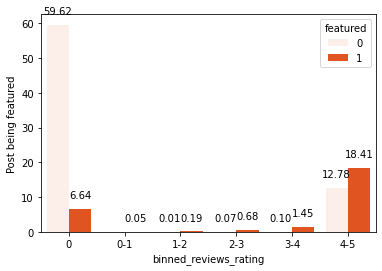

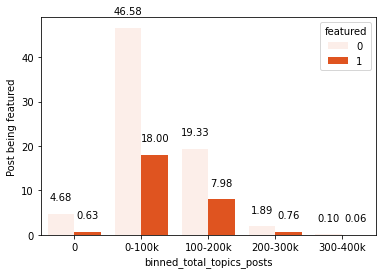

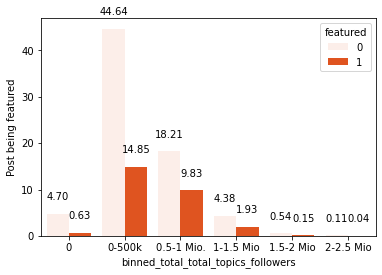

In [78]:
for feature in features_chart:
    get_liklihood_charts(liklihood_df, feature)